# Lung Cancer Survival Analysis

## SET UP WORKSPACE

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines import NelsonAalenFitter
from lifelines.statistics import logrank_test
from lifelines import CoxPHFitter   # For Cox-proportional Hazard Regression

In [2]:
# Load data
data = pd.read_csv('assets/lung.csv')

## EXPLORE DATA

In [3]:
# Inspect data
data.head()

,Unnamed: 0,inst,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss
0,1,3.0,306,2,74,1,1.0,90.0,100.0,1175.0,NaN
1,2,3.0,455,2,68,1,0.0,90.0,90.0,1225.0,15.0
2,3,3.0,1010,1,56,1,0.0,90.0,90.0,NaN,15.0
3,4,5.0,210,2,57,1,1.0,90.0,60.0,1150.0,11.0
4,5,1.0,883,2,60,1,0.0,100.0,90.0,NaN,0.0


In [4]:
# Check data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228 entries, 0 to 227
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  228 non-null    int64  
 1   inst        227 non-null    float64
 2   time        228 non-null    int64  
 3   status      228 non-null    int64  
 4   age         228 non-null    int64  
 5   sex         228 non-null    int64  
 6   ph.ecog     227 non-null    float64
 7   ph.karno    227 non-null    float64
 8   pat.karno   225 non-null    float64
 9   meal.cal    181 non-null    float64
 10  wt.loss     214 non-null    float64
dtypes: float64(6), int64(5)
memory usage: 19.7 KB


In [5]:
# Check descriptive stats
data_desc_stats = data.describe()
data_desc_stats

,Unnamed: 0,inst,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss
count,228.00000,227.000000,228.000000,228.000000,228.000000,228.000000,227.000000,227.000000,225.000000,181.000000,214.000000
mean,114.50000,11.088106,305.232456,1.723684,62.447368,1.394737,0.951542,81.938326,79.955556,928.779006,9.831776
std,65.96211,8.303491,210.645543,0.448159,9.073457,0.489870,0.717872,12.327955,14.623177,402.174707,13.139902
min,1.00000,1.000000,5.000000,1.000000,39.000000,1.000000,0.000000,50.000000,30.000000,96.000000,-24.000000
25%,57.75000,3.000000,166.750000,1.000000,56.000000,1.000000,0.000000,75.000000,70.000000,635.000000,0.000000
50%,114.50000,11.000000,255.500000,2.000000,63.000000,1.000000,1.000000,80.000000,80.000000,975.000000,7.000000
75%,171.25000,16.000000,396.500000,2.000000,69.000000,2.000000,1.000000,90.000000,90.000000,1150.000000,15.750000
max,228.00000,33.000000,1022.000000,2.000000,82.000000,2.000000,3.000000,100.000000,100.000000,2600.000000,68.000000


AxesSubplot(0.125,0.125;0.775x0.755)


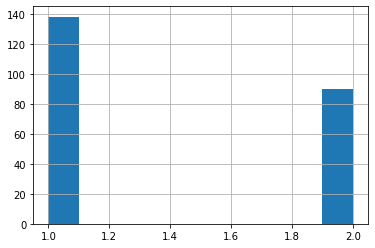

In [6]:
# Plot histogrm of sex column
print(data['sex'].hist())

## Kaplan-Meier Estimator

In [8]:
# Create KaplanMeieerFitter object
kmf = KaplanMeierFitter()

In [9]:
# Create is.dead column
# If status == 1, then is.dead == 0
# If status == 2, then is.dead == 1

data.loc[data.status == 1, 'is.dead'] = 0
data.loc[data.status == 2, 'is.dead'] = 1

# Check changes
data.head()

,Unnamed: 0,inst,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss,is.dead
0,1,3.0,306,2,74,1,1.0,90.0,100.0,1175.0,NaN,1.0
1,2,3.0,455,2,68,1,0.0,90.0,90.0,1225.0,15.0,1.0
2,3,3.0,1010,1,56,1,0.0,90.0,90.0,NaN,15.0,0.0
3,4,5.0,210,2,57,1,1.0,90.0,60.0,1150.0,11.0,1.0
4,5,1.0,883,2,60,1,0.0,100.0,90.0,NaN,0.0,1.0


In [10]:
# Fit parameters to kmf object
kmf.fit(durations = data['time'], event_observed = data['is.dead'])

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 228 total observations, 63 right-censored observations>

## Event Table

In [11]:
# Print event table
kmf.event_table

,removed,observed,censored,entrance,at_risk
event_at,,,,,
0.0,0,0,0,228,228
5.0,1,1,0,0,228
11.0,3,3,0,0,227
12.0,1,1,0,0,224
13.0,2,2,0,0,223
...,...,...,...,...,...
840.0,1,0,1,0,5
883.0,1,1,0,0,4
965.0,1,0,1,0,3


#### NOTE:
- removed = observed + censored
- censored = person that did not die
- observed = person that did die

- entrance = the number of new patients in a given timeline; new patients could be diagnosed during experiment
- at_risk = # current patiens observed; at_risk = current patients at_risk + entrance - removed

In [12]:
# Print descriptive stats of kmf event table
kmf.event_table.describe()

,removed,observed,censored,entrance,at_risk
count,187.000000,187.000000,187.000000,187.000000,187.000000
mean,1.219251,0.882353,0.336898,1.219251,108.288770
std,0.452060,0.636741,0.506811,16.673011,66.490941
min,0.000000,0.000000,0.000000,0.000000,1.000000
25%,1.000000,0.000000,0.000000,0.000000,50.500000
50%,1.000000,1.000000,0.000000,0.000000,107.000000
75%,1.000000,1.000000,1.000000,0.000000,163.000000
max,3.000000,3.000000,2.000000,228.000000,228.000000


## Predicting probabilities

### Survival probability for t=0

In [13]:
# Calculate survival probability at a given time
event_at_0 = kmf.event_table.iloc[0,:]

# Calculate survival probability for t-0
surv_for_0 = (event_at_0.at_risk - event_at_0.observed) / event_at_0.at_risk
surv_for_0

1.0

### Survival probability for t=5

In [14]:
# Calculate survival probability at a given time
event_at_5 = kmf.event_table.iloc[1,:]

# Calculate survival probability for t=5
surv_for_5 = (event_at_5.at_risk - event_at_5.observed) / event_at_5.at_risk
surv_for_5

0.9956140350877193

### Survival probability for t=11

In [15]:
# Calculate survival probability at a given time
event_at_11 = kmf.event_table.iloc[2,:]

# Calculate survival probability for t-0
surv_for_11 = (event_at_11.at_risk - event_at_11.observed) / event_at_11.at_risk
surv_for_11

0.986784140969163

In [16]:
# Probabilities of survival
print("Survival probability for t=0: ", kmf.predict(0))
print("Survival probability for t=5: ", kmf.predict(5))
print("Survival probability for t=11: ", kmf.predict(11))

Survival probability for t=0:  1.0
Survival probability for t=5:  0.9956140350877193
Survival probability for t=11:  0.9824561403508766


In [17]:
# Can do the above like this, too:
kmf.predict([0, 5, 11, 12])

0     1.000000
5     0.995614
11    0.982456
12    0.978070
Name: KM_estimate, dtype: float64

### Table of survival probabilities

In [18]:
# Or, you can make predictions for the entire timeline like this:
kmf.survival_function_

,KM_estimate
timeline,
0.0,1.000000
5.0,0.995614
11.0,0.982456
12.0,0.978070
13.0,0.969298
...,...
840.0,0.067127
883.0,0.050346
965.0,0.050346


### Plot of survival probabilities

Text(0, 0.5, 'Probability of survival')

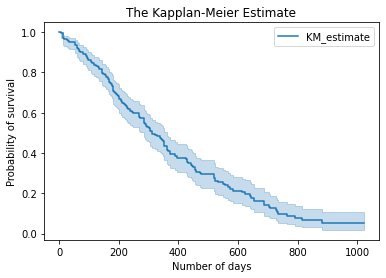

In [19]:
# Plot graph of probabilities
kmf.plot()
plt.title('The Kapplan-Meier Estimate')
plt.xlabel('Number of days')
plt.ylabel('Probability of survival')

## Median number of survival days
### Provides the number of days where, on average, 50% of the patients survived

In [20]:
# Print the median number of days where, on average, 50% of the patients survived
print('The median survival time: ', kmf.median_survival_time_)

The median survival time:  310.0


## Table of survival probability with confidence interval

In [21]:
# Print survival probabilities with confidence intervals
kmf.confidence_interval_survival_function_

,KM_estimate_lower_0.95,KM_estimate_upper_0.95
0.0,1.000000,1.000000
5.0,0.969277,0.999381
11.0,0.953935,0.993379
12.0,0.948120,0.990813
13.0,0.936682,0.985244
...,...,...
840.0,0.030728,0.123060
883.0,0.017866,0.108662
965.0,0.017866,0.108662
1010.0,0.017866,0.108662


## Plot of survival probability with confidence interval

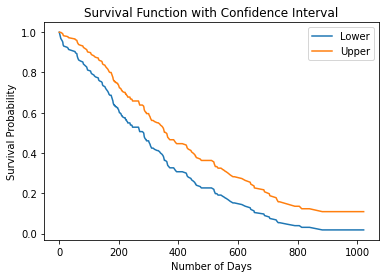

In [22]:
# Plot survival function with confidence interval
confidence_surv_func = kmf.confidence_interval_survival_function_

plt.plot(confidence_surv_func['KM_estimate_lower_0.95'], label='Lower')
plt.plot(confidence_surv_func['KM_estimate_upper_0.95'], label='Upper')
plt.title('Survival Function with Confidence Interval')
plt.xlabel('Number of Days')
plt.ylabel('Survival Probability')
plt.legend()

## Probability of a person dying at time t =
### number of subjects that died at time t / number of subjects at risk just before time t

In [23]:
# Print cumulative density

# Probability of a subject dying
# p(1022) = p(0) + ... + p(1022)
kmf.cumulative_density_

,KM_estimate
timeline,
0.0,0.000000
5.0,0.004386
11.0,0.017544
12.0,0.021930
13.0,0.030702
...,...
840.0,0.932873
883.0,0.949654
965.0,0.949654


## Plot of cumulative density

Text(0, 0.5, "Probability of person's death")

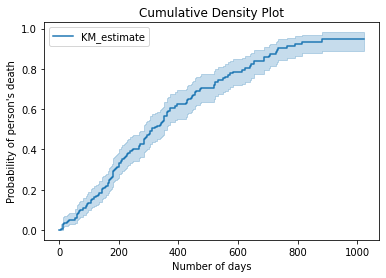

In [24]:
# Plot graph of cumulative density

kmf.plot_cumulative_density()
plt.title('Cumulative Density Plot')
plt.xlabel('Number of days')
plt.ylabel("Probability of person's death")

## Table of cumulative densities with a confidence interval

In [25]:
# Cumalative density with confidence interval
kmf.confidence_interval_cumulative_density_

,KM_estimate_lower_0.95,KM_estimate_upper_0.95
0.0,0.000000,0.000000
5.0,0.030723,0.000619
11.0,0.046065,0.006621
12.0,0.051880,0.009187
13.0,0.063318,0.014756
...,...,...
840.0,0.969272,0.876940
883.0,0.982134,0.891338
965.0,0.982134,0.891338
1010.0,0.982134,0.891338


## Plot cumulative density with a confidence interval

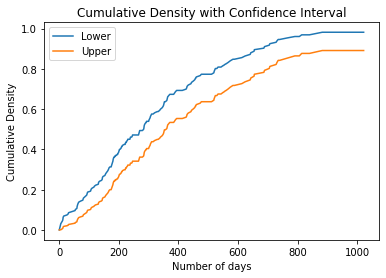

In [26]:
# Plot cumulative density with confidence interval

confidence_cumulative_density = kmf.confidence_interval_cumulative_density_

plt.plot(kmf.confidence_interval_cumulative_density_['KM_estimate_lower_0.95'], label='Lower')
plt.plot(kmf.confidence_interval_cumulative_density_['KM_estimate_upper_0.95'], label='Upper')
plt.title('Cumulative Density with Confidence Interval')
plt.xlabel('Number of days')
plt.ylabel('Cumulative Density')
plt.legend()

## Cumulative density for a particular time

In [27]:
# Find cumulative density at a specific time
kmf.cumulative_density_at_times(times=1022)

1022    0.949654
Name: KM_estimate, dtype: float64

## Median time to an event
### IE: the amount of time remaining from the median survival time

In [28]:
# Conditional median time to event of interest
kmf.conditional_time_to_event_

,KM_estimate - Conditional median duration remaining to event
timeline,
0.0,310.0
5.0,305.0
11.0,309.0
12.0,308.0
13.0,316.0
...,...
840.0,inf
883.0,inf
965.0,inf


# Plot of median time to the event

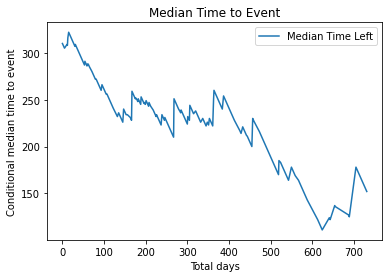

In [29]:
# Conditional median time left for event
median_time_to_event = kmf.conditional_time_to_event_
plt.plot(median_time_to_event, label='Median Time Left')
plt.title('Median Time to Event')
plt.xlabel('Total days')
plt.ylabel('Conditional median time to event')
plt.legend()

## Nelson-Aalen Estimator

In [30]:
# Create Nelson-Aalen Fitter object
naf = NelsonAalenFitter()

In [31]:
# Fit data to object
naf.fit(data['time'], event_observed=data['is.dead'])

<lifelines.NelsonAalenFitter:"NA_estimate", fitted with 228 total observations, 63 right-censored observations>

In [33]:
# Print cumulative hazard
naf.cumulative_hazard_

,NA_estimate
timeline,
0.0,0.000000
5.0,0.004386
11.0,0.017660
12.0,0.022125
13.0,0.031114
...,...
840.0,2.641565
883.0,2.891565
965.0,2.891565


## Plot of cumulative hazard

Text(0, 0.5, "Cumulative Probability of person's death")

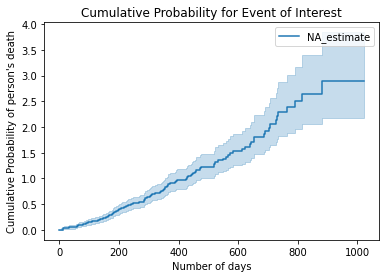

In [34]:
# Plot the cumulative hazard graph

naf.plot_cumulative_hazard()
plt.title('Cumulative Probability for Event of Interest')
plt.xlabel('Number of days')
plt.ylabel("Cumulative Probability of person's death")

## Predict values

In [35]:
# Predict the value at a certain point
print('Time = 500 days: ', naf.predict(500))
print('Time = 1022 days: ', naf.predict(1022))

Time = 500 days:  1.219546171331098
Time = 1022 days:  2.8915648373471052


## Table of cumulative hazard probabilities with confidence interval

In [36]:
# Cumulative hazard with confidence interval
naf.confidence_interval_

,NA_estimate_lower_0.95,NA_estimate_upper_0.95
0.0,0.000000,0.000000
5.0,0.000618,0.031136
11.0,0.006628,0.047055
12.0,0.009209,0.053156
13.0,0.014832,0.065266
...,...,...
840.0,2.058738,3.389389
883.0,2.176987,3.840697
965.0,2.176987,3.840697
1010.0,2.176987,3.840697


## Plot of cumulative hazard probability with confidence interval

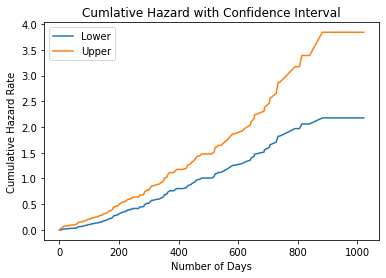

In [38]:
# Plot cumulative hazard rate with confidence interval
confidence_interval = naf.confidence_interval_

plt.plot(confidence_interval["NA_estimate_lower_0.95"], label='Lower')
plt.plot(confidence_interval["NA_estimate_upper_0.95"], label='Upper')
plt.title('Cumlative Hazard with Confidence Interval')
plt.xlabel('Number of Days')
plt.ylabel('Cumulative Hazard Rate')
plt.legend()

## Plot Cumulative Hazard vs. Cumulative Density

Text(0.5, 0, 'Number of Days')

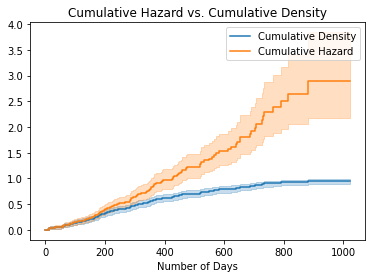

In [41]:
# Plot cumulative hazard vs cumultive density
kmf.plot_cumulative_density(label='Cumulative Density')
naf.plot_cumulative_hazard(label='Cumulative Hazard')
plt.title('Cumulative Hazard vs. Cumulative Density')
plt.xlabel('Number of Days')

## Kaplan-Meier Estimator with Groups
### Determine if there is any difference in survival probability if we divide our data into groups based on certain criteria.
### Here, the data are divided into two groups based on sex:
1. Male
2. Female

### Create Kaplan-Meier Fitter objects for each group

In [58]:
# Create two objects, one for male group and one for female group

#kmf_m for male data
kmf_m = KaplanMeierFitter()
kmf_f = KaplanMeierFitter()

### Divide data into two groups

In [43]:
# Divide data
male_data = data.query('sex == 1')
female_data = data.query('sex == 2')

In [46]:
# Inspect male data
male_data.head()

,Unnamed: 0,inst,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss,is.dead
0,1,3.0,306,2,74,1,1.0,90.0,100.0,1175.0,NaN,1.0
1,2,3.0,455,2,68,1,0.0,90.0,90.0,1225.0,15.0,1.0
2,3,3.0,1010,1,56,1,0.0,90.0,90.0,NaN,15.0,0.0
3,4,5.0,210,2,57,1,1.0,90.0,60.0,1150.0,11.0,1.0
4,5,1.0,883,2,60,1,0.0,100.0,90.0,NaN,0.0,1.0


In [51]:
# Inspect female data
female_data.head()

,Unnamed: 0,inst,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss,is.dead
6,7,7.0,310,2,68,2,2.0,70.0,60.0,384.0,10.0,1.0
7,8,11.0,361,2,71,2,2.0,60.0,80.0,538.0,1.0,1.0
11,12,16.0,654,2,68,2,2.0,70.0,70.0,NaN,23.0,1.0
12,13,11.0,728,2,68,2,1.0,90.0,90.0,NaN,5.0,1.0
18,19,1.0,61,2,56,2,2.0,60.0,60.0,238.0,10.0,1.0


In [60]:
# Fit data into objects
male_kmf = kmf_m.fit(durations=male_data['time'], event_observed=male_data['is.dead'], label='Male')
female_kmf = kmf_f.fit(durations=female_data['time'], event_observed=female_data['is.dead'], label='Female')

### Male group event table

In [61]:
# Event table for male group
male_kmf.event_table

,removed,observed,censored,entrance,at_risk
event_at,,,,,
0.0,0,0,0,138,138
11.0,3,3,0,0,138
12.0,1,1,0,0,135
13.0,2,2,0,0,134
15.0,1,1,0,0,132
...,...,...,...,...,...
814.0,1,1,0,0,5
840.0,1,0,1,0,4
883.0,1,1,0,0,3


### Female group event table

In [63]:
# Event table for female group
female_kmf.event_table

,removed,observed,censored,entrance,at_risk
event_at,,,,,
0.0,0,0,0,90,90
5.0,1,1,0,0,90
60.0,1,1,0,0,89
61.0,1,1,0,0,88
62.0,1,1,0,0,87
...,...,...,...,...,...
735.0,1,1,0,0,5
740.0,1,0,1,0,4
765.0,1,1,0,0,3


### Predicting survival probabilities

In [64]:
# Predict value based on time
print('Male survival probability at 11 days: ', kmf_m.predict(11))
print('Female survival probability at 11 days: ', kmf_f.predict(11))

Male survival probability at 11 days:  0.9782608695652172
Female survival probability at 11 days:  0.9888888888888887


In [65]:
# calculte survival probability for entire data set in group
kmf_male_survival_rates = kmf_m.survival_function_
kmf_female_survival_rates = kmf_f.survival_function_

Text(0, 0.5, 'Survival Probability')

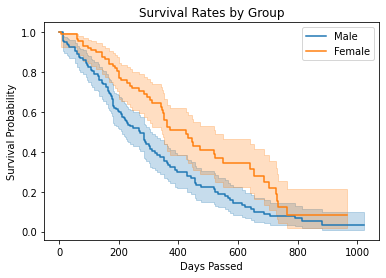

In [66]:
### Plot survival probabilities
kmf_m.plot()
kmf_f.plot()

plt.title('Survival Rates by Group')
plt.xlabel('Days Passed')
plt.ylabel('Survival Probability')

### Above, we can see that female lung cancer patients have a higher probability of surviving lung cancer than men. This information can be used to inform future research and policies.

## Cumlative Densities by Group

In [67]:
# # Cumlative density for male group
kmf_m.cumulative_density_

,Male
timeline,
0.0,0.000000
11.0,0.021739
12.0,0.028986
13.0,0.043478
15.0,0.050725
...,...
814.0,0.946429
840.0,0.946429
883.0,0.964286


In [68]:
# Cumulative density for female group
kmf_f.cumulative_density_

,Female
timeline,
0.0,0.000000
5.0,0.011111
60.0,0.022222
61.0,0.033333
62.0,0.044444
...,...
735.0,0.875178
740.0,0.875178
765.0,0.916786


## Plot Group Cumulative Densities

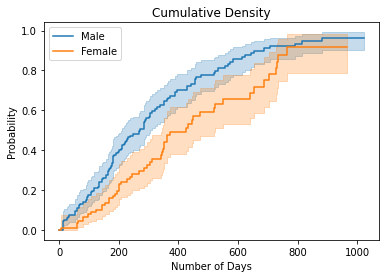

In [69]:
# Plot cumulative density for each group
kmf_m.plot_cumulative_density()
kmf_f.plot_cumulative_density()
plt.title('Cumulative Density')
plt.xlabel('Number of Days')
plt.ylabel('Probability')
plt.legend()

## Hazard Function

### Create objects for each group and fit relevant data

In [70]:
# Create objects
naf_m = NelsonAalenFitter()
naf_f = NelsonAalenFitter()

# Fit data
naf_m.fit(male_data['time'], event_observed=male_data['is.dead'])
naf_f.fit(female_data['time'], event_observed=female_data['is.dead'])

<lifelines.NelsonAalenFitter:"NA_estimate", fitted with 90 total observations, 37 right-censored observations>

## Cumulative Hazard Probability

In [71]:
# Cumulative hazard probability for male group
naf_m.cumulative_hazard_

,NA_estimate
timeline,
0.0,0.000000
11.0,0.021899
12.0,0.029306
13.0,0.044287
15.0,0.051863
...,...
814.0,2.831337
840.0,2.831337
883.0,3.164670


In [72]:
# Cumulative hazard probability for female group
naf_f.cumulative_hazard_

,NA_estimate
timeline,
0.0,0.000000
5.0,0.011111
60.0,0.022347
61.0,0.033711
62.0,0.045205
...,...
735.0,1.988977
740.0,1.988977
765.0,2.322310


## Plot Cumulative Hazard Probability for each group

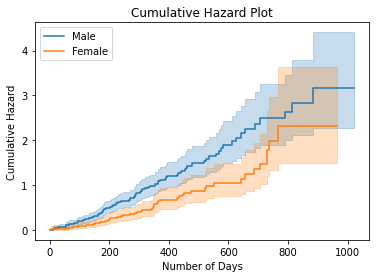

In [75]:
# Plot cumulative hazard probability for each group
naf_m.plot_cumulative_hazard(label='Male')
naf_f.plot_cumulative_hazard(label='Female')
plt.title('Cumulative Hazard Plot')
plt.xlabel('Number of Days')
plt.ylabel('Cumulative Hazard')
plt.legend(loc='upper left')

## Median time to event for male group

In [77]:
# Conditional median time to event of interest
kmf_m.conditional_time_to_event_

,Male - Conditional median duration remaining to event
timeline,
0.0,270.0
11.0,272.0
12.0,271.0
13.0,271.0
15.0,270.0
...,...
814.0,inf
840.0,inf
883.0,inf


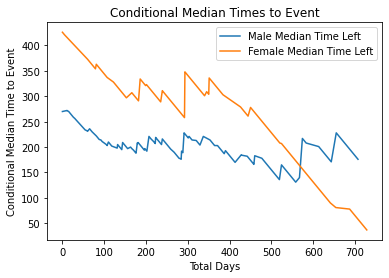

In [79]:
## Plot median time to event for each group
plt.plot(kmf_m.conditional_time_to_event_, label='Male Median Time Left')
plt.plot(kmf_f.conditional_time_to_event_, label='Female Median Time Left')
plt.title('Conditional Median Times to Event')
plt.xlabel('Total Days')
plt.ylabel('Conditional Median Time to Event')
plt.legend()

## Plot survival probability with confidence interval for male group

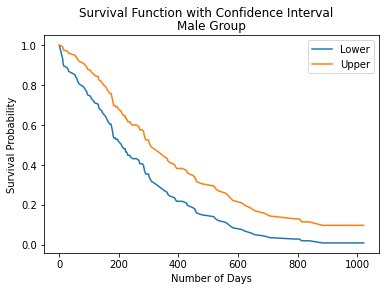

In [83]:
# Plot survival function with confidence interval for male group
confidence_surv_func = kmf_m.confidence_interval_survival_function_

plt.plot(confidence_surv_func['Male_lower_0.95'], label='Lower')
plt.plot(confidence_surv_func['Male_upper_0.95'], label='Upper')
plt.suptitle('Survival Function with Confidence Interval')
plt.title('Male Group')
plt.xlabel('Number of Days')
plt.ylabel('Survival Probability')
plt.legend()

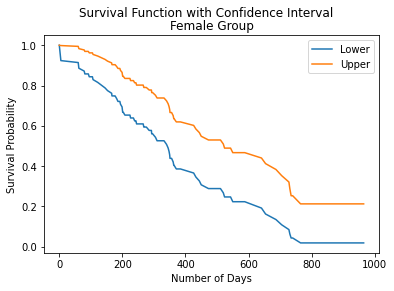

In [84]:
# Plot survival function with confidence interval for male group
confidence_surv_func = kmf_f.confidence_interval_survival_function_

plt.plot(confidence_surv_func['Female_lower_0.95'], label='Lower')
plt.plot(confidence_surv_func['Female_upper_0.95'], label='Upper')
plt.suptitle('Survival Function with Confidence Interval')
plt.title('Female Group')
plt.xlabel('Number of Days')
plt.ylabel('Survival Probability')
plt.legend()

## Comparison of cumulative density vs cumultive hazard

Text(0.5, 0, 'Number of Days')

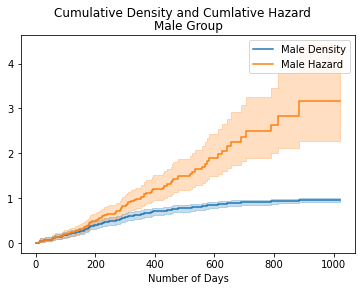

In [85]:
# Plot the cumulative hazard and cumulative density
kmf_m.plot_cumulative_density(label='Male Density')
naf_m.plot_cumulative_hazard(label='Male Hazard')
plt.suptitle('Cumulative Density and Cumlative Hazard')
plt.title('Male Group')
plt.xlabel('Number of Days')

Text(0.5, 0, 'Number of Days')

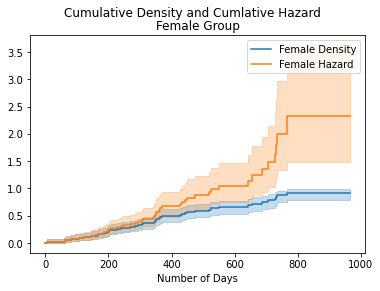

In [86]:
# Plot the cumulative hazard and cumulative density
kmf_f.plot_cumulative_density(label='Female Density')
naf_f.plot_cumulative_hazard(label='Female Hazard')
plt.suptitle('Cumulative Density and Cumlative Hazard')
plt.title('Female Group')
plt.xlabel('Number of Days')

## Log-Rank Test

In [90]:
# Define variables for Log-rank test
time_A = male_data['time']
event_A = male_data['is.dead']

time_B = female_data['time']
event_B = female_data['is.dead']

In [91]:
# Perform Log-rank test
results = logrank_test(time_A, time_B, event_observed_A=event_A, event_observed_B=event_B)
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          10.33 <0.005      9.57

In [92]:
# Print p-value
print('P-value: ', results.p_value)

P-value:  0.0013111645203554782


### With a p-value of 0.0013 (shown above), we must reject the null hypothesis that there is no statistically significant difference between the probability of survival for the male group and that of the female group.

### This p-value, in fact, is strong evidence that 'sex' was associated with the number of survival days.

## Cox-proportional Hazards Regression

In [94]:
# Prepare data
# Need to drop 'Unnamed: 0' column
cox_data = data.drop(['Unnamed: 0'], axis=1)
cox_data.head()

,inst,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss,is.dead
0,3.0,306,2,74,1,1.0,90.0,100.0,1175.0,NaN,1.0
1,3.0,455,2,68,1,0.0,90.0,90.0,1225.0,15.0,1.0
2,3.0,1010,1,56,1,0.0,90.0,90.0,NaN,15.0,0.0
3,5.0,210,2,57,1,1.0,90.0,60.0,1150.0,11.0,1.0
4,1.0,883,2,60,1,0.0,100.0,90.0,NaN,0.0,1.0


In [95]:
# Remove null values
subset_cols = ['inst', 'time', 'status', 'age', 'sex', 'ph.ecog', 'ph.karno',
                'pat.karno', 'meal.cal', 'wt.loss']
cox_data = data.dropna(subset=subset_cols)
cox_data.head()

,Unnamed: 0,inst,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss,is.dead
1,2,3.0,455,2,68,1,0.0,90.0,90.0,1225.0,15.0,1.0
3,4,5.0,210,2,57,1,1.0,90.0,60.0,1150.0,11.0,1.0
5,6,12.0,1022,1,74,1,1.0,50.0,80.0,513.0,0.0,0.0
6,7,7.0,310,2,68,2,2.0,70.0,60.0,384.0,10.0,1.0
7,8,11.0,361,2,71,2,2.0,60.0,80.0,538.0,1.0,1.0


In [98]:
# Get list of columns needed
cox_cols = ['time', 'age', 'sex', 'ph.ecog', 'ph.karno', 'pat.karno', 'meal.cal',
            'wt.loss', 'is.dead']

# Subset cox_data
cox_data = cox_data[cox_cols]

## Create Cox-proportional Hazard object and fit data

In [99]:
# Fit data and print summary
cph = CoxPHFitter()
cph.fit(cox_data, 'time', event_col='is.dead')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 167 total observations, 47 right-censored observations>
             duration col = 'time'
                event col = 'is.dead'
      baseline estimation = breslow
   number of observations = 167
number of events observed = 120
   partial log-likelihood = -494.03
         time fit was run = 2021-09-11 18:52:21 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
age         0.01       1.01       0.01            -0.01             0.03                 0.99                 1.03
sex        -0.55       0.57       0.20            -0.95            -0.16                 0.39                 0.85
ph.ecog     0.74       2.09       0.22             0.30             1.18                 1.35                 3.26
ph.karno    0.02       1.02       0.01             0.00             0.04                 1.00                 1.05
pat.karno  -0.01       0.99       0.01            -0.03             0.00                 0.97                 1.00
meal.cal    0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
wt.loss    -0.01       0.99       0.01            -0.03             0.00                 0.97                 1.00

              z      p   -log2(p)
covariate                        
age        0.93   0.35       1.51
sex       -2.75   0.01       7.37
ph.ecog    3.29 <0.005       9.95
ph.karno   2.00   0.05       4.45
pat.karno -1.49   0.14       2.87
meal.cal   0.11   0.91       0.13
wt.loss   -1.83   0.07       3.89
---
Concordance = 0.65
Partial AIC = 1002.07
log-likelihood ratio test = 28.16 on 7 df
-log2(p) of ll-ratio test = 12.25

### From the summary above, we can see that 'sex' and 'ph.ecog' have p-values less than 0.05. So, we should divide the data based on these two variables.

1. The 'sex' variable has a p-value of 0.01 and a Hazard Ratio (HR) of 0.57. This indicates a strong relationship between the subject's sex and decreased risk of death.
    * EG: Holding the other covariates constant, being female reduces the hazard by a factor of 0.57, or 43%. This means that females have higher chances of survival.
2. The 'ph.ecog' variable has a p-value <0.005 and a Hazard Ratio of 2.09. This indicates a strong relationship between the value of ph.ecog and increased risk of death.
    * EG: All other variables held constant, a subject witth a higher ph.ecog has 109% higher risk of death. This means that a higher value of ph.ecog is associated with poor survival.

## Plot Cox-proportional Hazard

Text(0.5, 1.0, 'Cox-proportional Hazard Plot')

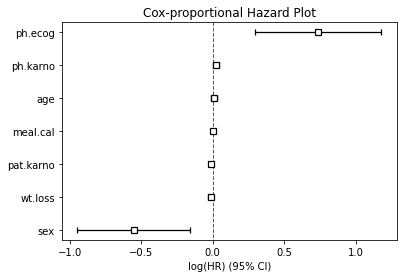

In [101]:
# Plot cph
cph.plot()
plt.title('Cox-proportional Hazard Plot')

## Check theory with real observations

In [103]:
# Check conclusions with real data from observations
d_data = cox_data.iloc[10:15,:]
d_data

,time,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss,is.dead
17,707,63,1,2.0,50.0,70.0,1025.0,22.0,1.0
18,61,56,2,2.0,60.0,60.0,238.0,10.0,1.0
20,301,67,1,1.0,80.0,80.0,1025.0,17.0,1.0
21,81,49,2,0.0,100.0,70.0,1175.0,-8.0,1.0
23,371,58,1,0.0,90.0,100.0,975.0,13.0,1.0


Text(0.5, 1.0, 'Survival Chances by Subject')

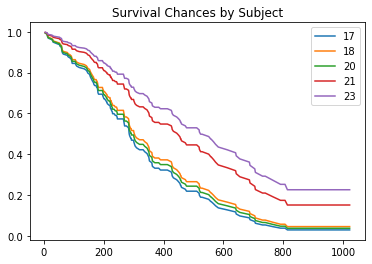

In [106]:
# Plot d_data
cph.predict_survival_function(d_data).plot()
plt.title('Survival Chances by Subject')

### Above, we can see that subject 23 hs the highest chance of survival and tht subject 17 has the lowest. By checking the main table, we can see a significant change in the value of the ph.ecog value. We can, also see that subjects 21 and 23 have higher chances of survival and that they have the lowest values of ph.ecog.